In [1]:
from rdkit import Chem
from rdkit.Chem import Draw
from copy import deepcopy
import pandas as pd
from pathlib import Path
from tqdm import tqdm
from IPython.display import SVG
import json
import ipywidgets as widgets
from ipywidgets import interact
from src.chem_draw import draw_molecule
from hydra import compose, initialize
import polars as pl
from functools import partial

with initialize(version_base=None, config_path="../conf/filepaths"):
    cfg = compose(config_name="filepaths")

In [2]:
kcs = pl.read_parquet(Path(cfg.known) / "known_compounds.parquet")
print(len(kcs))
kcs.head()

8603


id,smiles,names,n_atoms
str,str,list[str],i32
"""0""","""*""","[""A""]",1
"""1""","""**""","[""RX""]",2
"""2""","""*C""","[""an alkane""]",2
"""3""","""*C#N""","[""a nitrile""]",3
"""4""","""*C(*)(N)C(=O)O""","[""2,2-dialkylglycine""]",7


In [3]:
def patt_filter(smiles: str, patt: Chem.Mol) -> bool:
    """
    Check if the SMILES string matches the given RDKit pattern.
    """
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return False
    return mol.HasSubstructMatch(patt)

qty_C = '[#6]-[#6](-[#6])(-[#6])(-[#6])'
qty_c_filter = partial(patt_filter, patt=Chem.MolFromSmarts(qty_C))


qty_cs = kcs.filter(
    pl.col("smiles").map_elements(qty_c_filter, return_dtype=pl.Boolean)
).sort("n_atoms", descending=False)
print(len(qty_cs))
qty_cs.head()

[16:53:53] WARNING: not removing hydrogen atom with dummy atom neighbors


1828


[16:53:54] WARNING: not removing hydrogen atom with dummy atom neighbors
[16:53:54] WARNING: not removing hydrogen atom with dummy atom neighbors
[16:53:54] Unusual charge on atom 0 number of radical electrons set to zero
[16:53:54] Unusual charge on atom 0 number of radical electrons set to zero


id,smiles,names,n_atoms
str,str,list[str],i32
"""2324""","""CC(C)(C)C=O""","[""2,2-dimethylpropanal""]",6
"""1975""","""CC(=O)C(C)(C)C""","[""3,3-dimethylbutan-2-one""]",7
"""2323""","""CC(C)(C)C(O)C#N""","[""(2S)-2-hydroxy-3,3-dimethylbutanenitrile""]",8
"""2322""","""CC(C)(C)C(C)(O)C#N""","[""(2S)-2-hydroxy-2-methyl-3,3-dimethylbutanenitrile""]",9
"""3360""","""CC1(C)COC(=O)C1=O""","[""2-dehydropantolactone""]",9


In [ ]:
# Create a dropdown widget with the keys of qty_C_smiles
dropdown = widgets.Dropdown(
    options=[(row["names"][0], row) for row in qty_cs.iter_rows(named=True)],
    description='SMILES:',
    style={'description_width': 'initial'}
)

# Define a function to display the selected key
@interact
def display_molecule(row = dropdown):
    print(", ".join(row["names"]))
    display(SVG(draw_molecule(row["smiles"], size=(300, 300))))

interactive(children=(Dropdown(description='SMILES:', options=(('2,2-dimethylpropanal', {'id': '2324', 'smiles…

In [5]:
list(
        qty_cs[:10].with_columns(
            pl.col("names").list.first().alias("name")
        )[["smiles", "name"]].iter_rows()
    )

[('CC(C)(C)C=O', '2,2-dimethylpropanal'),
 ('CC(=O)C(C)(C)C', '3,3-dimethylbutan-2-one'),
 ('CC(C)(C)C(O)C#N', '(2S)-2-hydroxy-3,3-dimethylbutanenitrile'),
 ('CC(C)(C)C(C)(O)C#N', '(2S)-2-hydroxy-2-methyl-3,3-dimethylbutanenitrile'),
 ('CC1(C)COC(=O)C1=O', '2-dehydropantolactone'),
 ('CC1(C)COC(=O)C1O', '(R)-pantolactone'),
 ('C=C1C2CCC(C2)C1(C)C', '(1R,4S)-camphene'),
 ('C=C1CCC2(C(C)C)CC12', '(1R,5R)-sabinene'),
 ('C=C1CCC2CC1C2(C)C', '(1S,5S)-beta-pinene'),
 ('CC(C)(CO)C(=O)C(=O)O', '2-dehydropantoate')]

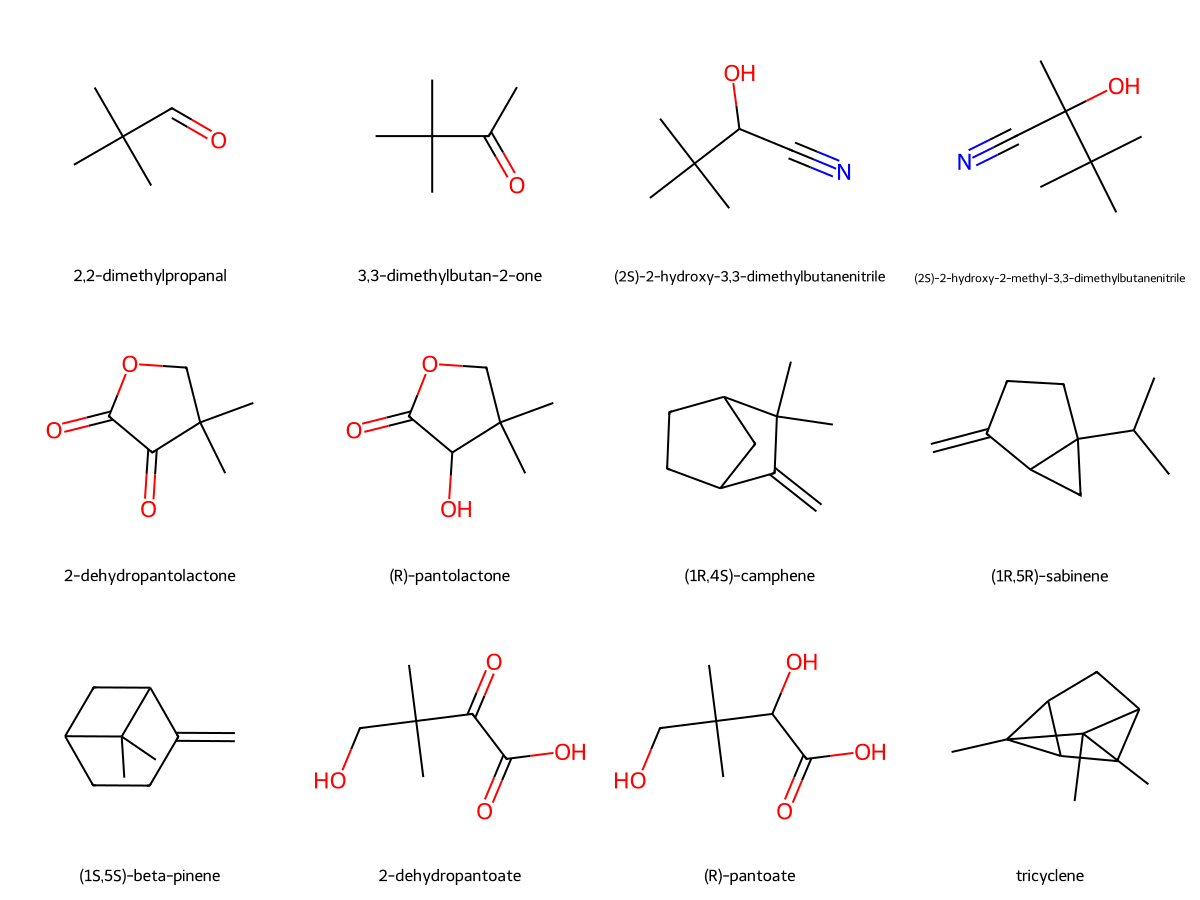

In [6]:
smiles, names = zip(
    *list(
        qty_cs[:12].with_columns(
            pl.col("names").list.first().alias("name")
        )[["smiles", "name"]].iter_rows()
    )
)

img =Draw.MolsToGridImage(
    [Chem.MolFromSmiles(s) for s in smiles],
    molsPerRow=4,
    subImgSize=(300, 300),
    legends=names,
    useSVG=True
)
display(img)

In [7]:
with open(Path(cfg.artifacts) / "illustrative_imgs" / "qty_c_mol_grid.svg", "w") as f:
    f.write(img.data)

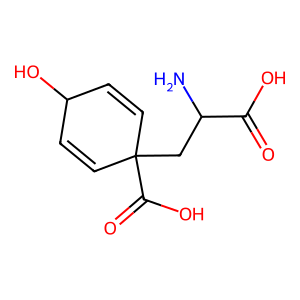

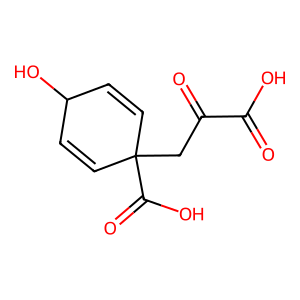

In [8]:
arogenate = draw_molecule(
    "NC(CC1(C(=O)O)C=CC(O)C=C1)C(=O)O",
    size=(300, 300),
)

prephenate = draw_molecule(
    "O=C(O)C(=O)CC1(C(=O)O)C=CC(O)C=C1",
    size=(300, 300),
)

with open(Path(cfg.artifacts) / "illustrative_imgs" / "arogenate.svg", "w") as f:
    f.write(arogenate)
with open(Path(cfg.artifacts) / "illustrative_imgs" / "prephenate.svg", "w") as f:
    f.write(prephenate)

display(SVG(arogenate))
display(SVG(prephenate))

In [9]:
arogenate

"<?xml version='1.0' encoding='iso-8859-1'?>\n<svg version='1.1' baseProfile='full'\n              xmlns='http://www.w3.org/2000/svg'\n                      xmlns:rdkit='http://www.rdkit.org/xml'\n                      xmlns:xlink='http://www.w3.org/1999/xlink'\n                  xml:space='preserve'\nwidth='300px' height='300px' viewBox='0 0 300 300'>\n<!-- END OF HEADER -->\n<rect style='opacity:1.0;fill:#FFFFFF;stroke:none' width='300.0' height='300.0' x='0.0' y='0.0'> </rect>\n<path class='bond-0 atom-0 atom-1' d='M 183.6,86.5 L 192.6,101.7' style='fill:none;fill-rule:evenodd;stroke:#0000FF;stroke-width:2.0px;stroke-linecap:butt;stroke-linejoin:miter;stroke-opacity:1' />\n<path class='bond-0 atom-0 atom-1' d='M 192.6,101.7 L 201.6,116.8' style='fill:none;fill-rule:evenodd;stroke:#000000;stroke-width:2.0px;stroke-linecap:butt;stroke-linejoin:miter;stroke-opacity:1' />\n<path class='bond-1 atom-1 atom-2' d='M 201.6,116.8 L 179.9,155.4' style='fill:none;fill-rule:evenodd;stroke:#00000

In [10]:
qty_cs.write_parquet(
    "/home/stef/krxns/data/raw/qty_c_cpds.parquet",
)